In [1]:
# %% Importing the libraries

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torchvision.transforms as T
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25

In [2]:
#%% Import Class & Functions

from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Python')

# CNN Class
import Class.CNN as CNN

# Function
from Function.dSplit import dSplit
import Function.LossFunc as LF
import Function.myDataset as mD

Mounted at /content/drive


In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
#%% Import data

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization with recommended values
                       ])

# import the data and apply the transform
dataset_train = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
dataset_test  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

print(f'dataset_train: {dataset_train.data.shape}')
print(f'dataset_test: {dataset_test.data.shape}')

# transform to dataloaders
batchsize    = 32
dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True, drop_last=True)
dataloader_test  = DataLoader(dataset_test, batch_size=256)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
dataset_train: (5000, 3, 96, 96)
dataset_test: (8000, 3, 96, 96)


Text(0, 0.5, 'torch dataset')

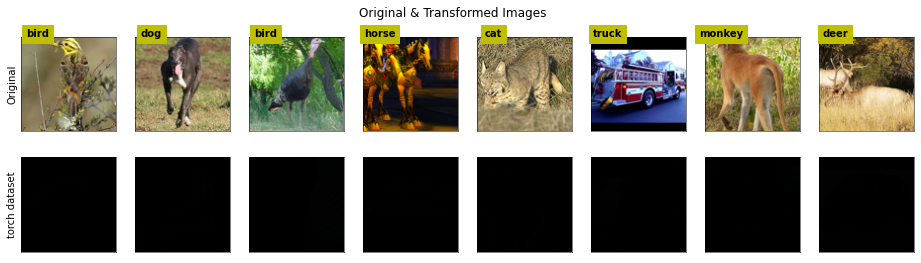

In [5]:
#%% plot some data in DataLoader

# import data from the dataloader
X, y = next(iter(dataloader_train))


# create a figure
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Original & Transformed Images')

# draw 8 first images
for i in range(8):

    # draw
    img = torch.tensor(dataset_train.data[i, :, :, :]).permute(1, 2, 0).int()
    axs[0, i].imshow(img)
    
    label = dataset_train.classes[dataset_train.labels[i]]
    axs[0, i].text(16, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    
    img = X[i, :, :, :].permute(1, 2, 0).int()
    axs[1, i].imshow(img.detach())
    

    for row in range(2):
      axs[row, i].set_xticks([])
      axs[row, i].set_yticks([])

# row labels
axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('torch dataset')

(array([33387.,  4671.,  5490., 26528., 11822., 16035., 19725., 21704.,
        24847., 21188., 26208., 22025., 22526., 23724., 23206., 25246.,
        24222., 28159., 24113., 29266., 24064., 25284., 25903., 29907.,
        22949., 21741., 22696., 18437., 22870., 22614., 21095., 21987.,
        18930., 14967., 13731., 11663., 11258.,  9195.,  8177.,  8476.,
         8561., 10752.,  6833.,  8880.,  8475.,  9480.,  3260.,  8155.,
         2364.,  7940.]),
 array([-2.1179, -2.0227, -1.9276, -1.8324, -1.7373, -1.6421, -1.547 ,
        -1.4518, -1.3566, -1.2615, -1.1663, -1.0712, -0.976 , -0.8808,
        -0.7857, -0.6905, -0.5954, -0.5002, -0.4051, -0.3099, -0.2147,
        -0.1196, -0.0244,  0.0707,  0.1659,  0.261 ,  0.3562,  0.4514,
         0.5465,  0.6417,  0.7368,  0.832 ,  0.9272,  1.0223,  1.1175,
         1.2126,  1.3078,  1.4029,  1.4981,  1.5933,  1.6884,  1.7836,
         1.8787,  1.9739,  2.0691,  2.1642,  2.2594,  2.3545,  2.4497,
         2.5448,  2.64  ], dtype=float32),
 <

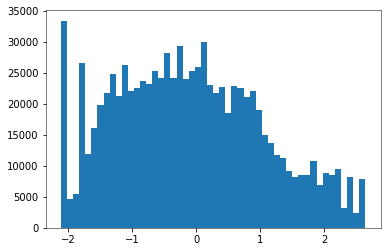

In [6]:
# check value in the img

# plot hist
x = X[:].view(-1, 1).detach().numpy()
plt.hist(x, 50)


In [8]:
# Import ResNet
resnet = torchvision.models.resnet18(pretrained=True)
resnet
summary(resnet.to(device), (3, 96, 96))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [9]:
# dir(resnet)
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [10]:
#%% Adjust output layer
resnet.fc = nn.Linear(512, 10)
print(f'output: {resnet.fc}\n')

#%%Freeze all the layers except output layer
for p in resnet.named_parameters():
    if 'fc' not in p[0]:
        p[1].requires_grad = False
        print(f'{p[0]}:requires_grad = {p[1].requires_grad}')
    
    else:
        print(f'\n{p[0]}:requires_grad = {p[1].requires_grad}')

output: Linear(in_features=512, out_features=10, bias=True)

conv1.weight:requires_grad = False
bn1.weight:requires_grad = False
bn1.bias:requires_grad = False
layer1.0.conv1.weight:requires_grad = False
layer1.0.bn1.weight:requires_grad = False
layer1.0.bn1.bias:requires_grad = False
layer1.0.conv2.weight:requires_grad = False
layer1.0.bn2.weight:requires_grad = False
layer1.0.bn2.bias:requires_grad = False
layer1.1.conv1.weight:requires_grad = False
layer1.1.bn1.weight:requires_grad = False
layer1.1.bn1.bias:requires_grad = False
layer1.1.conv2.weight:requires_grad = False
layer1.1.bn2.weight:requires_grad = False
layer1.1.bn2.bias:requires_grad = False
layer2.0.conv1.weight:requires_grad = False
layer2.0.bn1.weight:requires_grad = False
layer2.0.bn1.bias:requires_grad = False
layer2.0.conv2.weight:requires_grad = False
layer2.0.bn2.weight:requires_grad = False
layer2.0.bn2.bias:requires_grad = False
layer2.0.downsample.0.weight:requires_grad = False
layer2.0.downsample.1.weight:requ

In [11]:
# push model to device
resnet.to(device);

In [12]:
# Train model function
def trainModel(
    net,
    dataloader_train,
    dataloader_test,
    epochs,
    lossFun,
    optimizer,
    toggle_print=False,
    lr=0.001
  ):

    # optimizer
    optimizer = getattr(torch.optim, optimizer)
    optimizer = optimizer(net.parameters(), lr=lr)

    # initialize vars
    train_loss = torch.zeros(epochs)
    test_loss  = torch.zeros(epochs)
    train_acc  = torch.zeros(epochs)
    test_acc   = torch.zeros(epochs)

    # ---------------------
    # train mode
    # ---------------------
    for epochi in range(epochs):

      # switch to train mode
      net.train() 

      # init var
      batch_loss = []
      batch_acc  = []

      # loop over training batches
      for X, y in dataloader_train:

        # push to device
        X = X.to(device)
        y = y.to(device)

        # forward and loss
        yHat = net(X)
        loss = lossFun(yHat, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # store loss and compute accuracy from batch
        batch_loss.append(loss.item())
        batch_acc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      # ---**end of batch loop**---

      # average losses and accuracies for 1 epoch
      train_loss[epochi] = np.mean(batch_loss)
      train_acc[epochi]  = 100*np.mean(batch_acc)

      # ---------------------
      # test mode
      # ---------------------
      # switch to test mode
      net.eval() 

      # init var
      batch_loss = []
      batch_acc  = []

      for X, y in dataloader_test:

        # push to device
        X = X.to(device)
        y = y.to(device)

        # forward and loss
        with torch.no_grad():
          yHat = net(X)
          loss = lossFun(yHat, y)
        
        # store loss and compute accuracy from batch
        batch_loss.append(loss.item())
        batch_acc.append( torch.mean((torch.argmax(yHat, axis=1) == y).float()).item() )
      # ---**end of batch loop**---

      # average losses and accuracies for 1 epoch
      test_loss[epochi] = np.mean(batch_loss)
      test_acc[epochi]  = 100*np.mean(batch_acc)

      # print progress
      print(f'Epoch {epochi+1}/{epochs}.\n Test Acc = {test_acc[epochi]:.2f}%\n') if toggle_print==True else None

    return net, train_loss, train_acc, test_loss, test_acc


In [13]:
# Train net

# params
epochs = 10
lossfun = nn.CrossEntropyLoss()


# train
_, train_loss, train_acc, test_loss, test_acc = trainModel(
                                                            net=resnet,
                                                            dataloader_train=dataloader_train,
                                                            dataloader_test=dataloader_test,
                                                            epochs=10,
                                                            lossFun=lossfun,
                                                            optimizer='Adam',
                                                            toggle_print=True
                                                            )


Epoch 1/10.
 Test Acc = 76.46%

Epoch 2/10.
 Test Acc = 76.05%

Epoch 3/10.
 Test Acc = 78.08%

Epoch 4/10.
 Test Acc = 78.31%

Epoch 5/10.
 Test Acc = 78.70%

Epoch 6/10.
 Test Acc = 78.67%

Epoch 7/10.
 Test Acc = 79.00%

Epoch 8/10.
 Test Acc = 78.75%

Epoch 9/10.
 Test Acc = 78.70%

Epoch 10/10.
 Test Acc = 79.41%



Text(0.5, 1.0, 'Accuracy by Epoch(test set)')

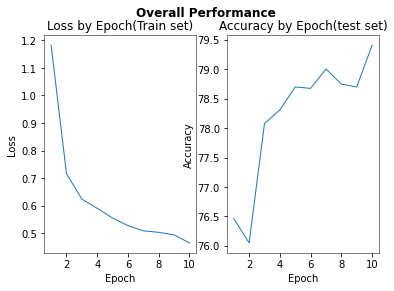

In [16]:
#%% plot model performance


# plot
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'Overall Performance', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)


# plot train-test acc-epoch by model
# plt.figure()
plt.subplot(1, 2, 1)
y_plot_1 = np.array(train_loss).T
y_plot_2 = np.mean(np.array(train_loss), axis=0)
# t, p = stats.ttest_ind(y_plot_1, y_plot_2)
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
# plt.plot(np.arange(1, epochs+1), y_plot_2, 'k', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss by Epoch(Train set)')
# plt.legend([f'{param}' for param in model_params_1] + ['Mean'])
# plt.legend(['Kaiming', 'Xavier'])

plt.subplot(1, 2, 2)
y_plot_1 = np.array(test_acc).T
y_plot_2 = np.mean(np.array(test_acc), axis=0)
# plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
# t, p = stats.ttest_ind(y_plot_1, y_plot_2)
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
# plt.plot(np.arange(1, epochs+1), y_plot_2, 'k', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy by Epoch(test set)')
# plt.legend([f'{param}' for param in model_params_1] + ['Mean'])
# plt.legend(['Kaiming', 'Xavier'])

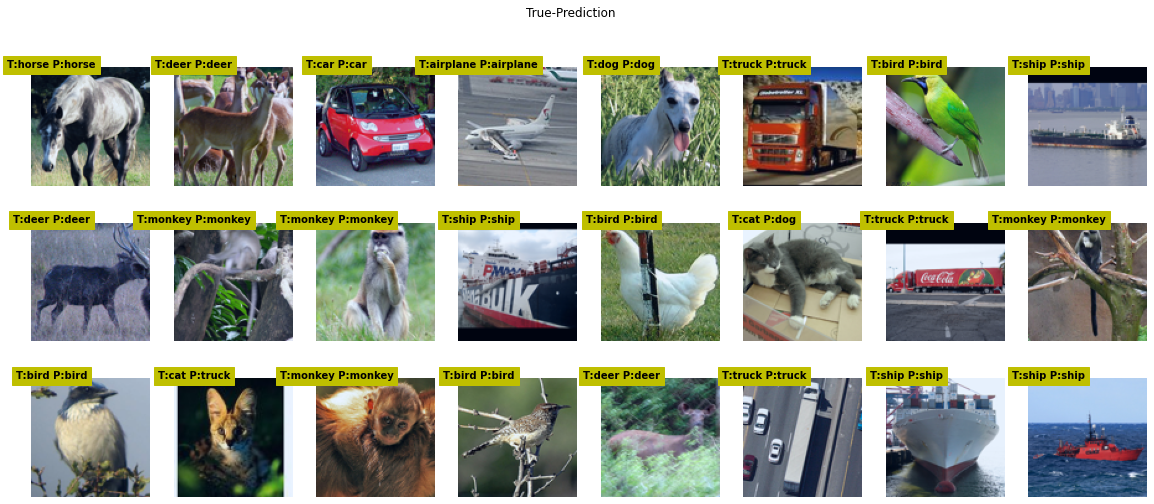

In [36]:
#%% Prediction from trained model

X, y = next(iter(dataloader_test))

X.to(device)
y.to(device)

labels = dataset_test.classes

# run the model through for the test data
# X = data_test_ind_ts.to(device)
# y = y_test_ind_ts.to(device)

# sample to show
nPic = 24
randId = np.random.choice(len(X), nPic, replace=False)

predictions = resnet.cpu()(X)
# predicitons = torch.sigmoid(predictions)
predictions = torch.argmax(predictions, axis=1)

fig, axs = plt.subplots(3, 8, figsize=(20, 8))
fig.suptitle('True-Prediction')

# original images from teh ind test set
for i, axi in enumerate(axs.flatten()):
    
    img = X[randId[i]].cpu().permute(1, 2, 0)
    # un-normalize
    img = img-torch.min(img) 
    img = img/torch.max(img)

    axi.imshow(img)
    axi.axis('off')
    # axi.set_title(f'T:{labels[y[randId[i]]]} P:{labels[predicitons[randId[i]]]}')
    label_t = f'T:{labels[y.cpu()[randId[i]]]} P:{labels[predictions[randId[i]]]}'
    axi.text(16, 0, label_t, ha='center', fontweight='bold', color='k', backgroundcolor='y')


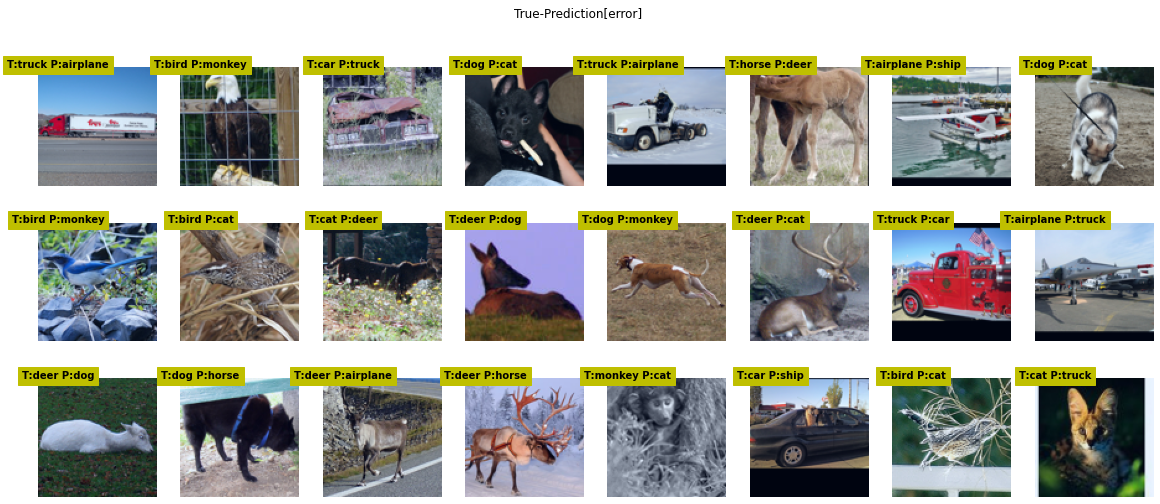

In [40]:
# plot some errors
nPic = 24
errors = np.where(predictions.cpu() != y.cpu())[0]
randId = np.random.choice(errors, nPic, replace=False)

fig, axs = plt.subplots(3, 8, figsize=(20, 8))
fig.suptitle('True-Prediction[error]')

# original images from teh ind test set
for i, axi in enumerate(axs.flatten()):
    
    img = X[randId[i]].cpu().permute(1, 2, 0)
    # un-normalize
    img = img-torch.min(img) 
    img = img/torch.max(img)
  
    axi.imshow(img)
    axi.axis('off')
    # axi.set_title(f'T:{labels[y[randId[i]]]} P:{labels[predicitons[randId[i]]]}')
    label_t = f'T:{labels[y.cpu()[randId[i]]]} P:{labels[predictions[randId[i]]]}'
    axi.text(16, 0, label_t, ha='center', fontweight='bold', color='k', backgroundcolor='y')

<ipython-input-42-08f351b27b16>:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_yticks(np.unique(y.cpu()) ,list(labels))


[Text(0, 0, 'airplane'),
 Text(0, 0, 'bird'),
 Text(0, 0, 'car'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'deer'),
 Text(0, 0, 'dog'),
 Text(0, 0, 'horse'),
 Text(0, 0, 'monkey'),
 Text(0, 0, 'ship'),
 Text(0, 0, 'truck')]

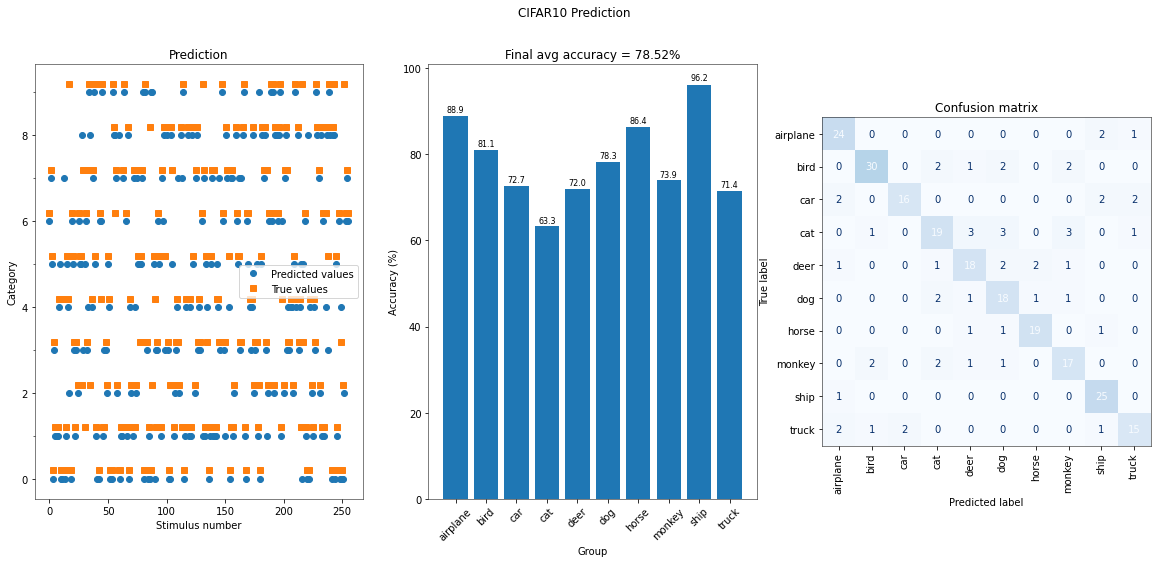

In [42]:
#%% plot accuracy by category

# and plot those against the real data
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('CIFAR10 Prediction')

axs[0].plot(predictions, 'o', label='Predicted values')
axs[0].plot(y.cpu()+.2, 's', label='True values')
axs[0].set_xlabel('Stimulus number')
axs[0].set_ylabel('Category')
axs[0].set_yticks(np.unique(y.cpu()) ,list(labels))
# plt.ylim()
axs[0].legend()
axs[0].set_title(f'Prediction')

accuracy = (predictions == y.cpu()).float()

# compute overall accuracy
totalAcc = torch.mean(100*accuracy).item()


# and average by group

accuracyByGroup = np.zeros(len(np.unique(y.cpu())))
for i in np.unique(y.cpu()):
    accuracyByGroup[int(i)] = 100*torch.mean(accuracy[y.cpu() == i])

rects1 = axs[1].bar(np.unique(y.cpu()), accuracyByGroup)
# plt.ylim([80, 100])
axs[1].set_xticks(np.unique(y.cpu()))
axs[1].set_xticklabels(list(labels), rotation = 45)
axs[1].set_xlabel('Group')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title(f'Final avg accuracy = {totalAcc:.2f}%')

def autolabel(rects, ax, size):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                f'{round(height, 1)}',
                ha='center', va='bottom', size=size)

autolabel(rects1, axs[1], 8)

# plot confusion matrix
axid = 2
fig.add_subplot(axs.flatten()[axid])
disp = skm.ConfusionMatrixDisplay.from_predictions(y.cpu(), predictions, ax=axs.flatten()[axid], colorbar=False, cmap='Blues')
disp.im_.set_clim(0, 100)
axs.flatten()[axid].title.set_text('Confusion matrix')
axs.flatten()[axid].set_xticks(np.unique(y.cpu()))
axs.flatten()[axid].set_xticklabels(list(labels), rotation = 90)
axs.flatten()[axid].set_yticks(np.unique(y.cpu()))
axs.flatten()[axid].set_yticklabels(list(labels))